In [1]:
import pandas as pd
import numpy as np

def repeat(df, N):
    "Repeat dataset N times, advancing index"
    dfs = []
    delta = df.index.max() - df.index.min()
    for i in range(N):
        df_copy = df.copy()
        df_copy.index = df.index + i*delta
        dfs.append(df_copy)
    return pd.concat(dfs)

def df_step(total_duration = "30d", error_duration = "6h", error_rate = 0.20):
    total_duration = pd.to_timedelta(total_duration)
    error_duration = pd.to_timedelta(error_duration)
    start_time = pd.Timestamp('2023-01-01')
    end_time = start_time + total_duration
    mid_time =  start_time + total_duration / 2

    df = pd.DataFrame(index=pd.date_range(start=start_time, end=end_time, freq='1min'))
    df['total'] = np.random.normal(loc=100, scale=2, size=len(df))
    df['total'] = df['total'].clip(lower=0)
    df['err_rate'] = 0
    df.loc[mid_time:mid_time + error_duration, 'err_rate'] = error_rate
    df['bad'] = df['total'] * df['err_rate']
    del df['err_rate']
    return df

def df_grafana(filename="data.csv"):
    df = pd.read_csv("data.csv")
    df["Time"] = pd.to_datetime(df["Time"])

    # remove duplicate index entries
    df = df.groupby('Time').first().reset_index() 

    # Normalize column names to "total", "bad"
    df.index = df["Time"]
    del df["Time"]
    df.columns = ['total', 'bad_pct']
    df["bad"] = df['total'] * df['bad_pct'] / 100
    df["good"] = df['total'] - df['bad']
    del df["bad_pct"]

    # Resample to one sample per minute
    df = df.asfreq('T').interpolate()
    df.index = df.index.round('T')

    # Round to nearest day boundaries
    start_date = df.index.min().replace(hour=0, minute=0, second=0) + pd.Timedelta(days=1)
    end_date = df.index.max().replace(hour=0, minute=0, second=0) - pd.Timedelta(days=2)
    df = df[start_date:end_date]

    return df

def df_csv(filename="data.csv"):
    df = pd.read_csv(filename, sep="\t", index_col="Time")
    df.index = pd.to_datetime(df.index)
    return df

import pandas as pd
import matplotlib.pyplot as plt

def df_skip(df, td):
    return df[df.index > df.index.min() + pd.Timedelta(td)]

def slo_plot(df, resolution='1min'):
    # Resample data
    df_resampled = df.resample(resolution).sum()


    # Create the plots
    fig, ax = plt.subplots(2, 1, figsize=(12, 4), gridspec_kw={'height_ratios': [3, 1]})

    # First Graph: Stacked area chart
    ax[0].stackplot(df_resampled.index, df_resampled['good'], df_resampled['bad'], 
                    labels=['Good', 'Bad'], colors=['lightgreen', 'darkred'])
    ax[0].legend(loc='upper left')
    ax[0].set_title('Good and Bad Events Over Time')
    ax[0].set_ylabel('Count')

    # Second Graph: Error rate
    error_rate = df_resampled['bad'] / df_resampled['total']
    ax[1].plot(df_resampled.index, error_rate, label='Error Rate', color='red')
    ax[1].set_title('Error Rate Over Time')
    ax[1].set_ylabel('Error Rate')
    ax[1].set_xlabel('Time')
    ax[1].set_ylim(0,1)

    plt.tight_layout()
    plt.show()

def inject_errors(df, start, end, rate):
    """
    Modifies df.good and df.bad between start and end timestamps to match the given error rate.
    
    Parameters:
    - df: DataFrame with columns 'good', 'bad', and 'total'
    - start: start timestamp
    - end: end timestamp
    - rate: desired error rate (between 0 and 1)
    """
    # Ensure rate is between 0 and 1
    if not (0 <= rate <= 1):
        raise ValueError("Error rate should be between 0 and 1.")

    # Filter rows between start and end
    mask = (df.index >= start) & (df.index <= end)

    # Calculate new bad values based on the desired error rate
    df.loc[mask, 'bad'] = df.loc[mask, 'total'] * rate

    # Adjust good values to keep total constant
    df.loc[mask, 'good'] = df.loc[mask, 'total'] - df.loc[mask, 'bad']

    return df

In [7]:
# Default Dataset
df = df_csv("../datasets/slo_requests.csv")
df = repeat(df,6)
df = inject_errors(df, "2023-08-17 12:00", "2023-08-17 18:00", 0.98)
df = inject_errors(df, "2023-08-14 00:00", "2023-08-14 04:00", 0.98)
df = df[:"2023-09-01"]
DF = df

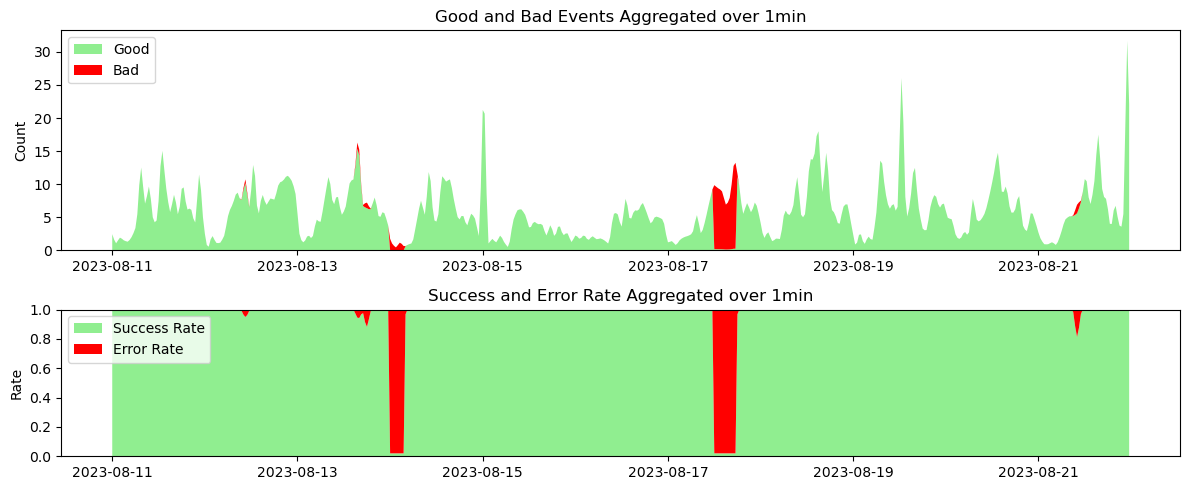

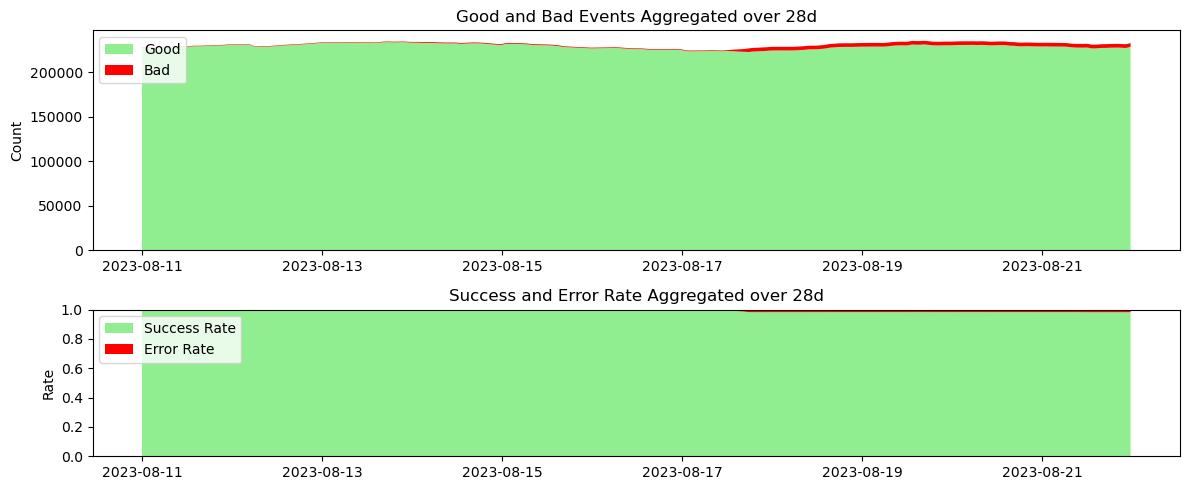

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo):
    df = df.copy()
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    return df

# Convert minutes to human-readable duration
def human_readable_duration(duration):
    minutes = pd.to_timedelta(duration).total_seconds() / 60
    if minutes < 60:
        return f"{minutes:.0f}min"
    elif minutes < 1440:
        return f"{minutes // 60:.0f}h"
    else:
        return f"{minutes // 1440:.0f}d"

def df_plot_prep(df, rng=None, res=None):
    out = df
    if rng:
        out = out[rng[0]: rng[1]]
    if res:
        out = out.resample(res).mean()
    return out
    
def slo_plot(df, agg_window="1min", plot_range=None, plot_res=None):
    df = df.rolling(agg_window).sum()
    df = df_slo(df, 0.99)
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(2, 1, figsize=(12, 5), gridspec_kw={'height_ratios': [3, 2]})
    
    ax[0].stackplot(df.index, df['good'], df['bad'],  labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Good and Bad Events Aggregated over {human_readable_duration(agg_window)}')
    ax[0].set_ylabel('Count')
    
    ax[1].stackplot(df.index, df.success_rate, df.error_rate, labels=['Success Rate', 'Error Rate'], colors=['lightgreen', 'red'])
    ax[1].legend(loc='upper left')
    ax[1].set_title(f'Success and Error Rate Aggregated over {human_readable_duration(agg_window)}')
    ax[1].set_ylabel('Rate')
    ax[1].set_ylim(0, 1)
    
    plt.tight_layout()
    return fig

df = DF.copy()

RANGE = ['2023-08-11','2023-08-21']

# df = repeat(df_grafana(),6)
# df = inject_errors(df, "2023-08-17 10:00", "2023-08-17 18:00", 0.9)
# df = inject_errors(df, "2023-08-07 01:00", "2023-08-07 04:00", 0.9)

slo_plot(df, "1min", plot_range=RANGE, plot_res="30min");
plt.show()
slo_plot(df, "28d", plot_range=RANGE, plot_res="30min");

# SLI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


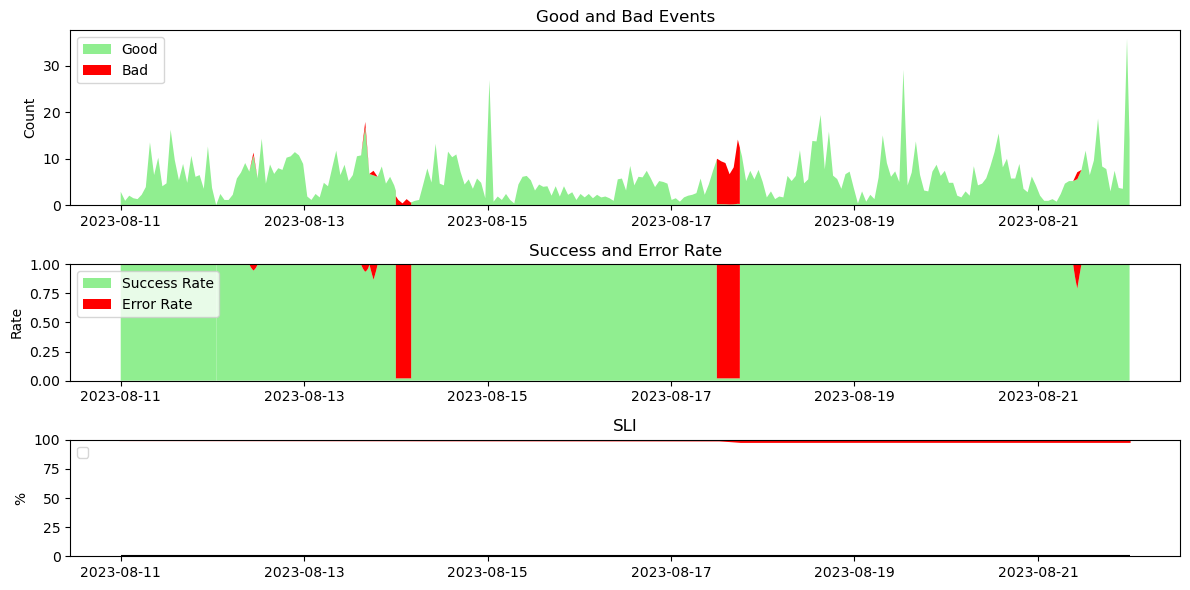

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo, period="7D"):
    df = df.copy()
    df['slo'] = slo
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    df['sli'] = df['good'].rolling(period).sum() / df['total'].rolling(period).sum()
    df['error_budget'] = (df['sli'] - slo) / (1 - slo)
    return df
    
def slo_plot2(df, plot_range=None, plot_res=None):
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(3, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2, 2]})
    
    ax[0].stackplot(df.index, df['good'], df['bad'], labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Good and Bad Events')
    ax[0].set_ylabel('Count')
    
    ax[1].stackplot(df.index, df.success_rate, df.error_rate, labels=['Success Rate', 'Error Rate'], colors=['lightgreen', 'red'])
    ax[1].legend(loc='upper left')
    ax[1].set_title(f'Success and Error Rate')
    ax[1].set_ylabel('Rate')
    ax[1].set_ylim(0, 1)

    ax[2].plot(df.index, df.sli * 100, color="red")
    ax[2].legend(loc='upper left')
    ax[2].set_title(f'SLI')
    ax[2].set_ylabel('%')
    ax[2].hlines([0], df.index.min(), df.index.max(), color="black")
    ax[2].set_ylim(0,100)
    
    plt.tight_layout()
    return fig

df = DF.copy()
df = df_slo(df, 0.98, "28D")
slo_plot2(df, plot_range=RANGE);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


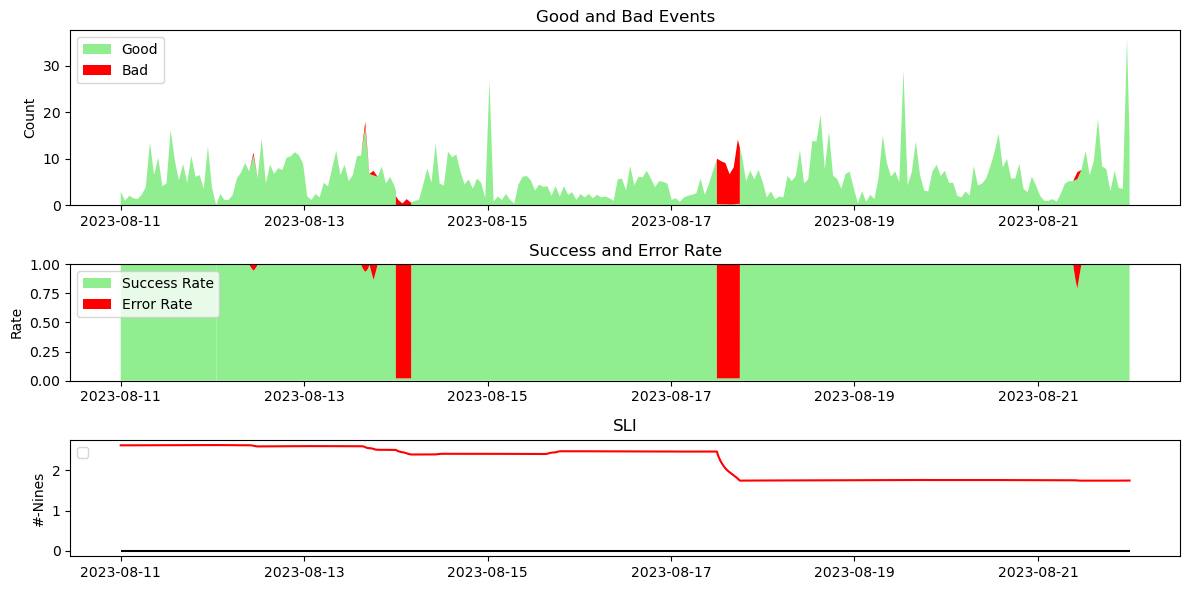

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo, period="7D"):
    df = df.copy()
    df['slo'] = slo
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    df['sli'] = df['good'].rolling(period).sum() / df['total'].rolling(period).sum()
    df['error_budget'] = (df['sli'] - slo) / (1 - slo)
    return df
    
def slo_plot2(df, plot_range=None, plot_res=None):
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(3, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2, 2]})
    
    ax[0].stackplot(df.index, df['good'], df['bad'], labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Good and Bad Events')
    ax[0].set_ylabel('Count')
    
    ax[1].stackplot(df.index, df.success_rate, df.error_rate, labels=['Success Rate', 'Error Rate'], colors=['lightgreen', 'red'])
    ax[1].legend(loc='upper left')
    ax[1].set_title(f'Success and Error Rate')
    ax[1].set_ylabel('Rate')
    ax[1].set_ylim(0, 1)

    ax[2].plot(df.index, -np.log(1-df.sli)/np.log(10), color="red")
    ax[2].legend(loc='upper left')
    ax[2].set_title(f'SLI')
    ax[2].set_ylabel('#-Nines')
    ax[2].hlines([0], df.index.min(), df.index.max(), color="black")
    
    plt.tight_layout()
    return fig

df = DF.copy()
df = df_slo(df, 0.98, "28D")
slo_plot2(df, plot_range=RANGE);

# Error Budget

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


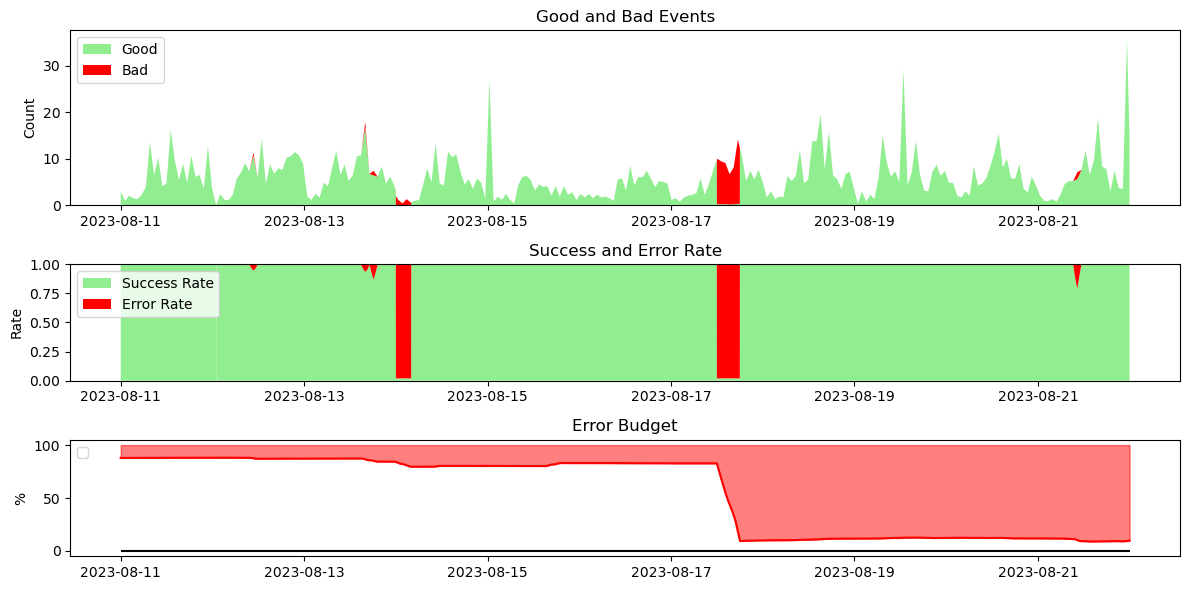

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo, period="7D"):
    df = df.copy()
    df['slo'] = slo
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    df['sli'] = df['good'].rolling(period).sum() / df['total'].rolling(period).sum()
    df['error_budget'] = (df['sli'] - slo) / (1 - slo)
    return df
    
def slo_plot2(df, plot_range=None, plot_res=None):
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(3, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2, 2]})
    
    ax[0].stackplot(df.index, df['good'], df['bad'], labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Good and Bad Events')
    ax[0].set_ylabel('Count')
    
    ax[1].stackplot(df.index, df.success_rate, df.error_rate, labels=['Success Rate', 'Error Rate'], colors=['lightgreen', 'red'])
    ax[1].legend(loc='upper left')
    ax[1].set_title(f'Success and Error Rate')
    ax[1].set_ylabel('Rate')
    ax[1].set_ylim(0, 1)

    ax[2].plot(df.index, df.error_budget * 100, color="red")
    ax[2].fill_between(df.index, df.error_budget * 100, 100, where=(df.error_budget * 100 <= 100), color='red', interpolate=True, alpha=0.5)
    ax[2].legend(loc='upper left')
    ax[2].set_title(f'Error Budget')
    ax[2].set_ylabel('%')
    ax[2].hlines([0], df.index.min(), df.index.max(), color="black")
    
    plt.tight_layout()
    return fig

df = DF.copy()
df = df_slo(df, 0.98, "28D")
slo_plot2(df, plot_range=RANGE);

# Burn Rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


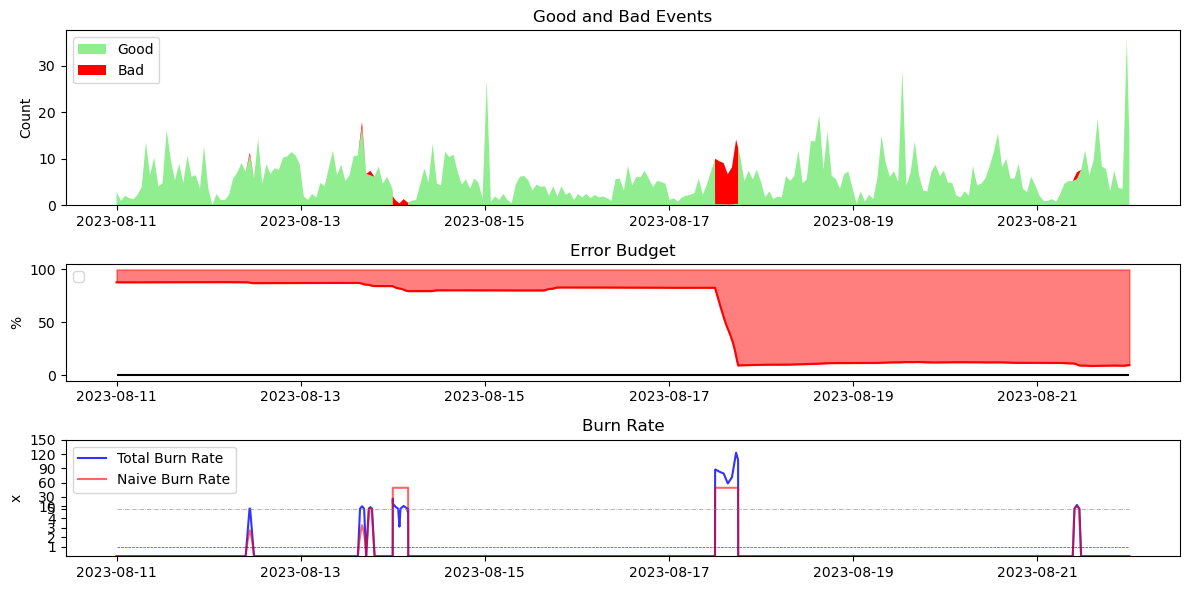

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo, period="7D"):
    N = pd.Timedelta(period) / pd.Timedelta("1min")
    def I(s): return s.rolling(period).sum()
    def A(s): return I(s) / N
    df = df.copy()
    df['slo'] = slo
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    df['sli'] = I(df['good']) / I(df['total'])
    df['error_budget'] = (df['sli'] - slo) / (1 - slo)
    df['burn_rate_naive'] = df['error_rate'] / (1-slo)
    df['burn_rate_total'] = df['bad']/A(df['total']) / (1-slo)
    return df

from matplotlib.lines import Line2D
def slo_plot3(df, plot_range=None, plot_res=None):
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(3, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2, 2]})
    
    ax[0].set_title(f'Good and Bad Events')
    ax[0].stackplot(df.index, df['good'], df['bad'], labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_ylabel('Count')
    
    ax[1].set_title(f'Error Budget')
    ax[1].plot(df.index, df.error_budget * 100, color="red")
    ax[1].fill_between(df.index, df.error_budget * 100, 100, where=(df.error_budget * 100 <= 100), color='red', interpolate=True, alpha=0.5)
    ax[1].legend(loc='upper left')
    ax[1].set_ylabel('%')
    ax[1].hlines([0], df.index.min(), df.index.max(), color="black")

    def _burn_scale(b):
        if b < 5: return b
        else: return 5 + (b-5)/20
    ticks = [1, 2, 3, 4, 5, 10, 30, 60, 90, 120, 150]

    ax[2].set_title(f'Burn Rate')
    ax[2].plot(df.index, df.burn_rate_total.apply(_burn_scale), color="blue", alpha=0.8, label="Total Burn Rate")
    ax[2].plot(df.index, df.burn_rate_naive.apply(_burn_scale), color="red",  alpha=0.6, label="Naive Burn Rate")
    ax[2].set_yticks([_burn_scale(y) for y in ticks])
    ax[2].set_yticklabels([str(y) for y in ticks])
    ax[2].legend(loc='upper left')
    ax[2].set_ylabel('x')
    ax[2].hlines([1], df.index.min(), df.index.max(), color="blue", linestyle="--", alpha=0.8, linewidth=0.5)
    ax[2].hlines([5], df.index.min(), df.index.max(), color="grey", linestyle="-.", alpha=0.8, linewidth=0.5)
    ax[2].set_ylim(0,_burn_scale(max(ticks)))
    
    
    plt.tight_layout()
    return fig

df = DF.copy()
df = df_slo(df, 0.98, "28D")
slo_plot3(df, plot_range=RANGE);

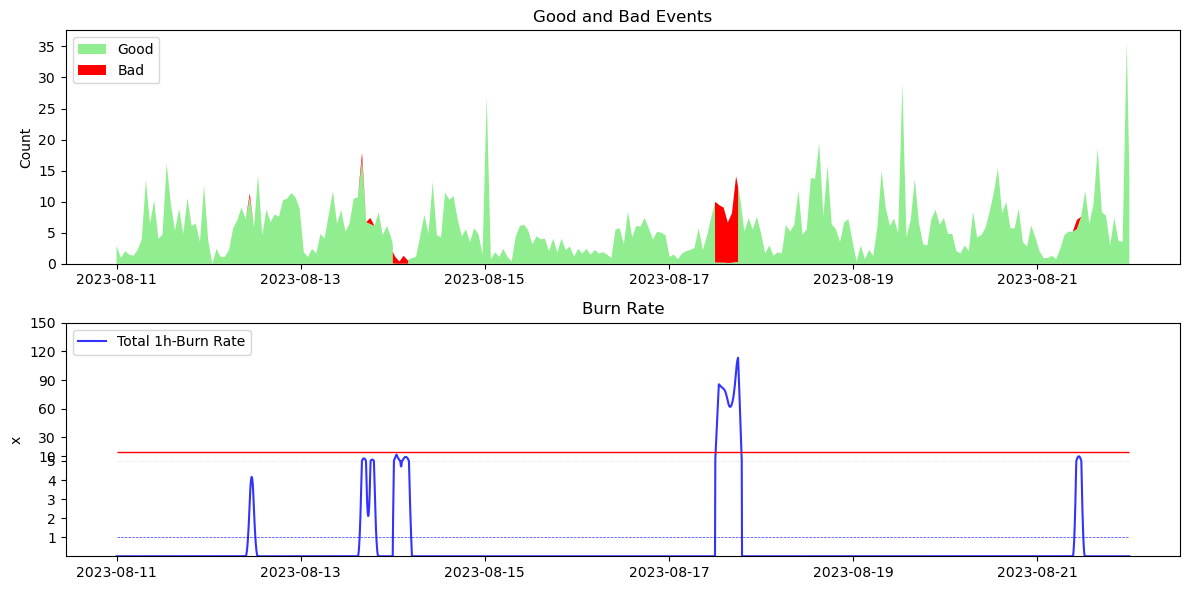

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def df_slo(df, slo, period="7D"):
    N = pd.Timedelta(period) / pd.Timedelta("1min")
    M = pd.Timedelta(period) / pd.Timedelta("1h")
    def I(s): return s.rolling(period).sum()
    def A(s): return I(s) / N
    df = df.copy()
    df['slo'] = slo
    df['error_rate'] = df['bad'] / df['total']
    df['success_rate'] = 1 - df.error_rate
    df['sli'] = I(df['good']) / I(df['total'])
    df['error_budget'] = (df['sli'] - slo) / (1 - slo)
    df['burn_rate_naive'] = df['error_rate']/ (1-slo)
    df['burn_rate_total'] = df['bad'].rolling("1h").sum()*M / I(df['total']) / (1-slo)
    return df

from matplotlib.lines import Line2D
def slo_plot3(df, plot_range=None, plot_res=None):
    df = df_plot_prep(df, plot_range, plot_res)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 3]})
    
    ax[0].set_title(f'Good and Bad Events')
    ax[0].stackplot(df.index, df['good'], df['bad'], labels=['Good', 'Bad'], colors=['lightgreen','red'])
    ax[0].legend(loc='upper left')
    ax[0].set_ylabel('Count')
    
    def _burn_scale(b):
        if b < 5: return b
        else: return 5 + (b-5)/20
    ticks = [1, 2, 3, 4, 5, 10, 30, 60, 90, 120, 150]

    ax[1].set_title(f'Burn Rate')
    ax[1].plot(df.index, df.burn_rate_total.apply(_burn_scale), color="blue", alpha=0.8, label="Total 1h-Burn Rate")
    # ax[1].plot(df.index, df.burn_rate_naive.apply(_burn_scale), color="green",  alpha=0.8, label="Naive Burn Rate")
    ax[1].set_yticks([_burn_scale(y) for y in ticks])
    ax[1].set_yticklabels([str(y) for y in ticks])
    ax[1].legend(loc='upper left')
    ax[1].set_ylabel('x')
    ax[1].hlines([1], df.index.min(), df.index.max(), color="blue", linestyle="--", alpha=0.8, linewidth=0.5)
    ax[1].hlines([5], df.index.min(), df.index.max(), color="grey", linestyle="-.", alpha=0.2, linewidth=0.5)
    ax[1].hlines([_burn_scale(14)], df.index.min(), df.index.max(), color="red", linestyle="-", alpha=1, linewidth=1)
    ax[1].set_ylim(0,_burn_scale(max(ticks)))
    
    plt.tight_layout()
    return fig


df = DF.copy()
df = df_slo(df, 0.98, "28D")
slo_plot3(df, plot_range=RANGE);

Rendering 180 frames.
....................................................................................................................................................................................

/tmp/ipykernel_82/1308407146.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_82/1308407146.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


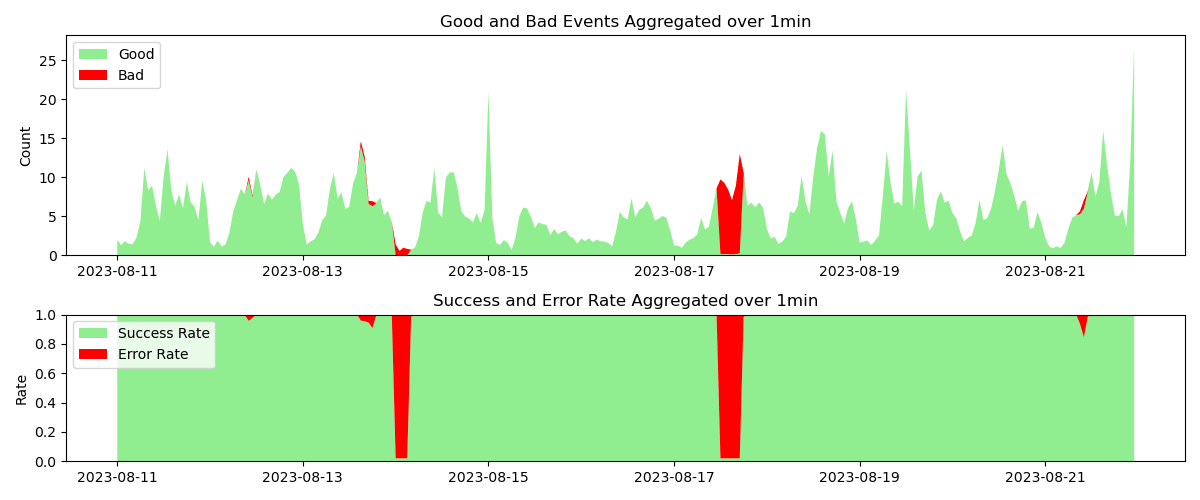

In [14]:
import numpy as np
import imageio
from IPython.display import display, Image
import os
import shutil

# Define a function to interpolate the aggregation windows
def interpolate_windows(start, end, num_frames):
    start_minutes = pd.to_timedelta(start).total_seconds() / 60
    end_minutes = pd.to_timedelta(end).total_seconds() / 60
    interpolated_minutes = np.linspace(start_minutes, end_minutes, num_frames)
    return [f"{int(minute)}min" for minute in interpolated_minutes]


frames = 60

agg_windows  = []
agg_windows += interpolate_windows('1min', '1D', frames)
agg_windows += interpolate_windows('1D',   '7D', frames)
agg_windows += interpolate_windows('7D',   '28D', frames)

total_duration = 15
frame_duration = total_duration / len(agg_windows)
print(f"Rendering {len(agg_windows)} frames.")

# Ensure the tmp directory exists
if not os.path.exists('./tmp'):
    os.makedirs('./tmp')

image_files = []

for window in agg_windows:
    print(".", end='')
    fig = slo_plot(df, window, plot_range = ['2023-08-11','2023-08-21'], plot_res = "1h")
    filename = f"./tmp/plot_{window}.png"
    fig.savefig(filename)
    image_files.append(filename)
    plt.close(fig)

# Create the GIF
gif_filename = 'animated_plot.gif'
with imageio.get_writer(gif_filename, mode='I', duration=frame_duration) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

    filename = image_files[-1]
    image = imageio.imread(filename)
    for _ in range(30):
        writer.append_data(image)
        

# Display the GIF in Jupyter notebook
with open(gif_filename, 'rb') as f:
    display(Image(data=f.read(), format='png'))

# Clean up the individual image files and the tmp directory
shutil.rmtree('./tmp')